# Проект для "Викишоп" c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

# Загрузка данных

Для начала, импортируем все необходимые для работы библиотеки

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


**Импорт библиотек**

In [3]:
import numpy as np
import pandas as pd

# import datasets

from tqdm import tqdm

import torch
# import transformers

from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
import transformers

import multiprocessing

from pymystem3 import Mystem
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE


from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import tensorflow

import torch

import random

import warnings

#pillow
import PIL

from wordcloud import WordCloud 

Сторонние библиотеки были загружены с помощью `pip install`, некоторые ячейки эти убраны (чтобы много места не занимали)

**Следующие этапы:**

- Загрузка датасета
- Подготовка признаков с `Bert`
- Удаление из текста мусорных символов
- Токенизация

**Загрузка датасета**

In [4]:
#data = pd.read_csv('/Users/kirillvolosnikov/Desktop/Datasets/toxic_comments.csv')

#data.head()

# Также еще есть вариант загрузки, при котором первый столбец у нас 
# сразу станет индексом датафрейма, но оставим пока так, чтобы потом ручками его убрать


data = pd.read_csv('/Users/kirillvolosnikov/Desktop/Datasets/toxic_comments.csv', index_col = 0)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Проверим данные на пропуски, корректность всех типов**

**Типы**

In [5]:
data.dtypes

text     object
toxic     int64
dtype: object

С типами данных все в порядке

**Пропуски**

In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков нет, все хорошо

**Проверим данные**

In [7]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
#data['Unnamed: 0'].head(30)

Уберем столбец `data['Unnamed : 0']`, т.к. он не несет инофрмативности и к тому же дублирует индексы

data = data.drop('Unnamed: 0', axis = 1)
data.head()

**Очистим колонку с текстом от мусорных символов**

In [9]:
def clean_data(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = " ".join(text.split())
    return text

In [10]:
data['text'] = data['text'].apply(clean_data)
data.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


Отлично, в тексте остались буквы и пробелы, как раз то, что нужно

**Проверка данных на дисбаланс + построение wordcloud**

In [11]:
text_raw = " ".join(data['text'])

text_raw[:500]

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk p'

Выведем облако слов

In [12]:
%matplotlib inline

wordcloud = WordCloud().generate(text_raw)

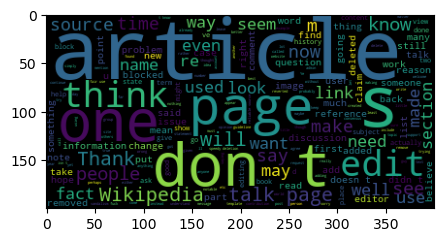

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)

По облаку слов видно, что самое популярное слово 'article', но какой-то конкретной информации об этом сказать нельзя)

**Дисбаланс**

In [14]:
data['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

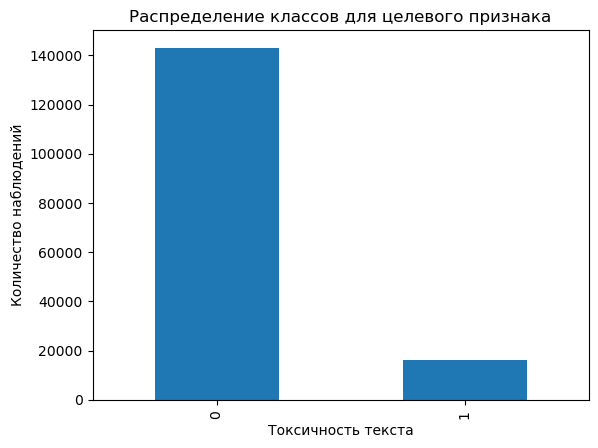

In [15]:
data['toxic'].value_counts().plot(
    kind = 'bar',
    title = 'Распределение классов для целевого признака',
    xlabel = 'Токсичность текста',
    ylabel = 'Количество наблюдений'
)

plt.show()

Дисбаланс очень большой, поэтому модель вероятно будет плохо предсказывать истинный класс, поэтому воспользуемся `up-down scaling`'ом с помощью `SMOTE` на этапе обучения модели в `pipeline`

**Теперь подготовим данные с помощью `Bert`**

Инициализируем конфигурацию `BertConfig`

In [16]:
#config = transformers.BertConfig.from_json_file(
#    '/Users/kirillvolosnikov/Desktop/Datasets/Bert/rubert_cased_L-12_H-768_A-12_pt_v1/config.json')

Затем инициализируем саму модель класса `BertModel`. Передадим ей файл с предобученной моделью и конфигурацией

In [17]:
#model = transformers.BertModel.from_pretrained(
#    '/Users/kirillvolosnikov/Desktop/Datasets/Bert/rubert_cased_L-12_H-768_A-12_pt_v1/pytorch_model.bin', config=config)

Загрузим `toxic-bert` в `AutoModel` и с помощью него уже проведем токенизацию текста заново 

In [18]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

**Токенизация текста**

In [19]:
# Этот токенайзер использовать не будем, т.к. уже загрузили специальный для toxic-bert

#tokenizer = transformers.BertTokenizer(vocab_file = '/Users/kirillvolosnikov/Desktop/Datasets/Bert/rubert_cased_L-12_H-768_A-12_pt_v1/vocab.txt')

In [20]:
# Добавим тестовый датафрейм, состоящий из 10000 строк, чтобы проверить работу модели (работает или нет, тк обучается очень долго каждый раз)

df = data[:10000].copy()

df.shape

(10000, 2)

In [21]:
df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


In [22]:
%%time
#tokenized = data['text'].apply(lambda x: tokenizer.encode(x, padding = True, truncation = True, max_length =  50, add_special_tokens = True))

tokenized = df['text'].apply(lambda x: tokenizer.encode(x, padding = True, truncation = True, max_length =  50, add_special_tokens = True))

CPU times: user 2.47 s, sys: 958 ms, total: 3.43 s
Wall time: 2.35 s


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Устройство, на котором работает Jupyter:", device)

Устройство, на котором работает Jupyter: cpu


In [24]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

50

In [25]:
%%time
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

CPU times: user 29.7 ms, sys: 1.19 ms, total: 30.9 ms
Wall time: 31.9 ms


In [26]:
attention_mask = np.where(padded != 0, 1, 0)

In [27]:
attention_mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

**Начнём преобразование текстов в эмбеддинги**

In [28]:
%%time

batch_size = 400
embeddings = []



for i in tqdm(range(padded.shape[0]//batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|                                                    | 0/25 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|███████████████████████████████████████████| 25/25 [05:30<00:00, 13.21s/it]

CPU times: user 17min 16s, sys: 7min 55s, total: 25min 12s
Wall time: 5min 30s


In [29]:
features = np.concatenate(embeddings)
#target = data['toxic']
target = df['toxic']

In [30]:
print(features.shape)
print(target.shape)

(10000, 768)
(10000,)


In [31]:
target = target[:features.shape[0]]
print(target.shape)

(10000,)


In [32]:
features

array([[-0.39243168, -0.86664593,  0.75231725, ..., -0.82746226,
         0.69355565,  0.2480279 ],
       [-0.47206053, -0.84122026,  0.72919333, ..., -0.81908464,
         0.6471293 ,  0.22821176],
       [-0.5344636 , -0.74311274,  0.8432172 , ..., -0.72624695,
         0.5951438 ,  0.15647538],
       ...,
       [-0.39003062, -0.74476916,  0.4977306 , ..., -0.8351898 ,
         0.700126  ,  0.43365014],
       [-0.6336476 , -0.8699488 ,  0.74933326, ..., -0.844386  ,
         0.49391878,  0.12392909],
       [-0.5501916 , -0.7535319 ,  0.62581694, ..., -0.8653288 ,
         0.57048064,  0.20793408]], dtype=float32)

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.2, random_state=12345)

Здесь я сделаю срез данных, чтобы по ним прогнать обучение (оооочень долго выполняется код, поэтому нужно узнать, не поломан ли он)

In [34]:
features_train_1000, features_test_1000, target_train_1000, target_test_1000 = features_train[:1000],features_test[:1000], target_train[:1000],target_test[:1000]


**Подведение итоговое подготовки**
- Изучили данные, проверили основную информацию о датасете.

- Далее использовали Bert'а, чтобы создать эммбединги комментарев.


На руках имеем датасет с признаками, на которых можно обучать модель

# Обучение Моделей

**Обучение будет включать в себя следующие этапы:**

- Обучим Логическую регрессию
- Обучим Catboost 
- Обучим SGDClassifier
- Сравним результаты

Итак, данные уже были подготовлены, разделены на выборки, можно приступить к написанию `pipeline`

## LogisticRegression

In [35]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
#warnings.filterwarnings('ignore')

In [36]:
#%%time

#for _ in tqdm(range(1), desc='Fitting GridSearchCV'):
#    pipe_l_r = Pipeline([
#        ('model', LogisticRegression(random_state=RANDOM_STATE, solver='saga'))
#    ])

#    param_grid_l_r = [
#        {
#            'model__C': np.arange(.1, 1., .3),
#            'model__penalty': ['l1', 'l2'],
#            'model__max_iter': range(20, 400, 100)
#        }]
#    grid_l_r = GridSearchCV(pipe_l_r, param_grid=param_grid_l_r, scoring='f1', cv=5, verbose=True)

#    best_grid_l_r = grid_l_r.fit(features_train, target_train)

#print('Best parameters is:', grid_l_r.best_params_)
#print('Best score is:', grid_l_r.best_score_)
kf = KFold(n_splits= 3 )

pipe_l = Pipeline([
    (('model', LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')))
    ])

param_grid_l = [
        {   'model': [LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')],
             'model__C': np.arange(.1,1.,.3),
            'model__penalty':['l1', 'l2'],
            'model__max_iter': range(20, 400, 100)
        }]
grid_l = GridSearchCV(pipe_l, param_grid=param_grid_l, scoring='f1', cv=kf, verbose=True)

In [37]:
#%%time
best_grid_l = grid_l.fit(features_train, target_train)

print('Best parameters is:', grid_l.best_params_)
print('Best score is:', grid_l.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters is: {'model': LogisticRegression(C=0.7000000000000001, class_weight='balanced', max_iter=20,
                   penalty='l1', random_state=12345, solver='liblinear'), 'model__C': 0.7000000000000001, 'model__max_iter': 20, 'model__penalty': 'l1'}
Best score is: 0.8426577456841516


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**CatBoost с дисбалансом**

In [38]:
#%%time 

kf = KFold(n_splits = 5)
pipe_cat = Pipeline([
    (('model', CatBoostClassifier(random_state=12345, scale_pos_weight = 7)))
    ])

param_grid_cat = [
        {   
             'model__iterations': np.arange(50,201,50),
            'model__learning_rate':np.arange(0.1,0.3,0.1)
        }]
grid_cat = GridSearchCV(pipe_cat, param_grid=param_grid_cat, scoring='f1', cv=kf, verbose=True)


best_grid_cat = grid_cat.fit(features_train, target_train)
print('Best parameters is:', grid_cat.best_params_)
print('Best score is:', grid_cat.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 0.5555402	total: 127ms	remaining: 6.24s
1:	learn: 0.4460134	total: 157ms	remaining: 3.77s
2:	learn: 0.3738592	total: 186ms	remaining: 2.91s
3:	learn: 0.3198328	total: 214ms	remaining: 2.46s
4:	learn: 0.2782536	total: 242ms	remaining: 2.18s
5:	learn: 0.2427395	total: 270ms	remaining: 1.98s
6:	learn: 0.2189706	total: 298ms	remaining: 1.83s
7:	learn: 0.1999200	total: 326ms	remaining: 1.71s
8:	learn: 0.1858052	total: 356ms	remaining: 1.62s
9:	learn: 0.1754542	total: 384ms	remaining: 1.54s
10:	learn: 0.1648835	total: 412ms	remaining: 1.46s
11:	learn: 0.1561934	total: 440ms	remaining: 1.39s
12:	learn: 0.1495566	total: 468ms	remaining: 1.33s
13:	learn: 0.1434997	total: 496ms	remaining: 1.27s
14:	learn: 0.1392576	total: 524ms	remaining: 1.22s
15:	learn: 0.1353492	total: 551ms	remaining: 1.17s
16:	learn: 0.1315134	total: 582ms	remaining: 1.13s
17:	learn: 0.1280579	total: 610ms	remaining: 1.08s
18:	learn: 0.1249656	total: 637m

Получили лучшие метрики, теперь по ним запустим `cross_val`

In [39]:
model_cat_imb = CatBoostClassifier(random_state = RANDOM_STATE, iterations = 200, learning_rate = 0.2)

cross_val_cat_imb = cross_val_score(model_cat_imb, features_train, target_train)


0:	learn: 0.3581153	total: 49.2ms	remaining: 9.79s
1:	learn: 0.2107976	total: 161ms	remaining: 15.9s
2:	learn: 0.1356725	total: 221ms	remaining: 14.5s
3:	learn: 0.1061351	total: 282ms	remaining: 13.8s
4:	learn: 0.0919954	total: 340ms	remaining: 13.3s
5:	learn: 0.0814047	total: 392ms	remaining: 12.7s
6:	learn: 0.0741534	total: 447ms	remaining: 12.3s
7:	learn: 0.0697559	total: 500ms	remaining: 12s
8:	learn: 0.0671656	total: 559ms	remaining: 11.9s
9:	learn: 0.0640919	total: 611ms	remaining: 11.6s
10:	learn: 0.0617742	total: 667ms	remaining: 11.5s
11:	learn: 0.0601030	total: 725ms	remaining: 11.4s
12:	learn: 0.0584790	total: 778ms	remaining: 11.2s
13:	learn: 0.0564971	total: 834ms	remaining: 11.1s
14:	learn: 0.0556820	total: 885ms	remaining: 10.9s
15:	learn: 0.0547077	total: 942ms	remaining: 10.8s
16:	learn: 0.0534111	total: 994ms	remaining: 10.7s
17:	learn: 0.0522593	total: 1.05s	remaining: 10.6s
18:	learn: 0.0513406	total: 1.1s	remaining: 10.5s
19:	learn: 0.0501966	total: 1.15s	remaining

**SGDClassifier**

In [41]:
# %%time
# clf = Pipeline([
#     ('smote' , SMOTE(random_state = RANDOM_STATE)),
#     ('model' , SGDClassifier(random_state = RANDOM_STATE))
# ])



# param_grid_sgd = [
#     {
#     'model' : [SGDClassifier(random_state = RANDOM_STATE)],
#     'model__loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'model__penalty':['l1','l2'],
#     'model__max_iter':range(10,150,30)
#     }
# ]

# grid_SGD = GridSearchCV(clf, param_grid = param_grid_sgd, scoring = 'f1', verbose = True)

# best_grid_sgd = grid_SGD.fit(features_train, target_train)

# print('Best parameters is:', grid_SGD.best_params_)
# print('Best score is:', grid_SGD.best_score_)

pipe_sgd = Pipeline([
    (('model', SGDClassifier(random_state=12345, loss='hinge', max_iter=100)))
    ])
param_grid_sgd = [
        {   'model': [SGDClassifier(random_state=12345, loss='hinge')],
            'model__penalty':['l1', 'l2'],
            'model__max_iter': range(20, 100, 30)
        }]
grid_sgd = GridSearchCV(pipe_sgd, param_grid=param_grid_sgd, scoring='f1', cv=kf, verbose=True)

best_grid_sgd = grid_sgd.fit(features_train, target_train)
print('Best parameters is:', best_grid_sgd.best_params_)
print('Best score is:', best_grid_sgd.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/line

Best parameters is: {'model': SGDClassifier(max_iter=50, random_state=12345), 'model__max_iter': 50, 'model__penalty': 'l2'}
Best score is: 0.8624022702318636


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


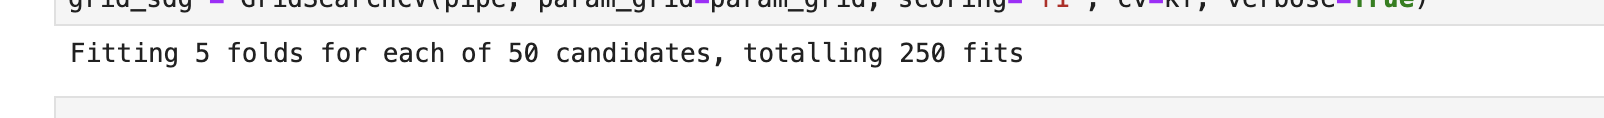

**Сравним полученные значения для моделей:**

In [42]:
print('Лучшее значение метрики для модели LogisticRegression: ', grid_l.best_score_)
print('Лучшее значение метрики для модели CatBoost: ', grid_cat.best_score_)
print('Лучшее значение метрики для модели SGDClassifier: ', best_grid_sgd.best_score_)

Лучшее значение метрики для модели LogisticRegression:  0.8426577456841516
Лучшее значение метрики для модели CatBoost:  0.8701946827433572
Лучшее значение метрики для модели SGDClassifier:  0.8624022702318636


Итак, лучшая модель - `CatBoost`, теперь проверим тестовую выборку на ней

## Тестирование на тестовой выборке 

In [43]:
model_cat_final = CatBoostClassifier(random_state = RANDOM_STATE, iterations = 200, learning_rate = 0.2)

model_cat_final.fit(features_train, target_train)

preds_cat = model_cat_final.predict(features_test)

cat_score = f1_score(target_test, preds_cat)

print(f"Final CatBoost score = {cat_score}")

0:	learn: 0.3499294	total: 37.4ms	remaining: 7.44s
1:	learn: 0.2145308	total: 71ms	remaining: 7.03s
2:	learn: 0.1410322	total: 102ms	remaining: 6.71s
3:	learn: 0.1104990	total: 135ms	remaining: 6.59s
4:	learn: 0.0936119	total: 174ms	remaining: 6.79s
5:	learn: 0.0823539	total: 234ms	remaining: 7.55s
6:	learn: 0.0757711	total: 299ms	remaining: 8.24s
7:	learn: 0.0709282	total: 348ms	remaining: 8.34s
8:	learn: 0.0673837	total: 395ms	remaining: 8.39s
9:	learn: 0.0645518	total: 450ms	remaining: 8.56s
10:	learn: 0.0628459	total: 506ms	remaining: 8.69s
11:	learn: 0.0617734	total: 561ms	remaining: 8.79s
12:	learn: 0.0605544	total: 611ms	remaining: 8.79s
13:	learn: 0.0590682	total: 667ms	remaining: 8.86s
14:	learn: 0.0581733	total: 720ms	remaining: 8.88s
15:	learn: 0.0566547	total: 775ms	remaining: 8.91s
16:	learn: 0.0556900	total: 828ms	remaining: 8.92s
17:	learn: 0.0549319	total: 879ms	remaining: 8.89s
18:	learn: 0.0540306	total: 935ms	remaining: 8.9s
19:	learn: 0.0532526	total: 988ms	remainin

Получили результат - 0.86, что очень хорошо и годится для использования на реальных данных

# Выводы
Подведем итоги, мы провели работу по обучению моделей для магазина "Викишоп", чтобы по тексту комментария модель понимала, что содержится какая-то недопустимая информация в тексте и этот комментарий отправлялся на модерацию.

Наша работа состоит из 9 этапов:

- Импорты
- - Импортировали все необходимые для работы с моделями библиотеки + добавили модель toxic-bert на англ, которая помогает с эмбединнгами
- Скачивание датасетов
- Исследование данных
- - Исследовали данные на пропуски (не было), дисбаланс классов (присутствует, но в моделях использовали методы, такие как class_weight или smote, чтобы с ними бороться)
- Исправление дисбаланса
- Эксперименты с Bert
- Применение Bert
- Обучение нескольких моделей
- - Были обучены несколько моделей, и лучшей оказался CatBoostClassifier (от любимого Яндекса), с итоговой метрикой на тестовых данных 0.86, что является допустимой метрикой в этой задаче (условие: f1_score > 0.75) 
- Tест лучшей модели
- - Лучшая модель была протестирована на тестовых данных.
- Подведение итогов